<a href="https://colab.research.google.com/github/divya-r-kamat/MnistLite-8k/blob/main/MnistLite_8k_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNist Neural Network

The goal is to achieve 99.4% validation/test accuracy consistently, with less than 15 epochs and 8k parameters

### Target:

- Make the model lighter (reduce parameter count, stay < 8k)
- Use Global Average Pooling (GAP) → reduces overfitting, removes need for large dense layer
- Add BatchNorm after convs → stabilize training, faster convergence, better generalization


### Results:

- Parameters: 5.6k
- Best Training Accuracy: 99.48%
- Best Test Accuracy: By Epoch 13–15: ~99.0–99.18%.

### Analysis

- lighter model + GAP + BN gave better stability, fewer params, and accuracy that scales above 99% by 13–15 epochs.
- still a bit short of the 99.4% milestone (peaked at ~99.18%).
- Notice how training loss is stable and doesn’t collapse/oscillate.
- This iteration is clearly more efficient and better aligned with our goal compared to the first model.

### Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt

### Check if cuda is available

In [2]:
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")

CUDA Available? True


### Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


### Reload the data with computed mean and std deviation

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.38MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Model Architecture

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(1, 8, 3)   # 28 -> 26
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 10, 3)  # 26 -> 24
        self.bn2 = nn.BatchNorm2d(10)
        self.pool1 = nn.MaxPool2d(2, 2)   # 24 -> 12
        # Transition
        self.conv3 = nn.Conv2d(10, 8, 1)
        self.bn3 = nn.BatchNorm2d(8)

        # Block 2
        self.conv4 = nn.Conv2d(8, 16, 3)  # 12 -> 10
        self.bn4 = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(16, 16, 3)  # 10 -> 8
        self.bn5 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2, 2)    # 8 -> 4

        # Transition
        self.conv6 = nn.Conv2d(16, 10, 1)
        self.bn6 = nn.BatchNorm2d(10)
        self.conv7 = nn.Conv2d(10, 10, 3)  # 4 - > 2

        # GAP instead of conv7
        self.gap = nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool2(x)

        x = F.relu(self.bn6(self.conv6(x)))
        x = self.conv7(x)

        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)


### Check if CUDA is available and display model parameters


In [6]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
            Conv2d-3           [-1, 10, 24, 24]             730
       BatchNorm2d-4           [-1, 10, 24, 24]              20
         MaxPool2d-5           [-1, 10, 12, 12]               0
            Conv2d-6            [-1, 8, 12, 12]              88
       BatchNorm2d-7            [-1, 8, 12, 12]              16
            Conv2d-8           [-1, 16, 10, 10]           1,168
       BatchNorm2d-9           [-1, 16, 10, 10]              32
           Conv2d-10             [-1, 16, 8, 8]           2,320
      BatchNorm2d-11             [-1, 16, 8, 8]              32
        MaxPool2d-12             [-1, 16, 4, 4]               0
           Conv2d-13             [-1, 10, 4, 4]             170
      BatchNorm2d-14             [-1, 1

### Print model architecture

In [7]:
print(model)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 8, kernel_size=(1, 1), stride=(1, 1))
  (bn3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv2d(16, 10, kernel_size=(1, 1), stride=(1, 1))
  (bn6): BatchNorm2

### Load train and test data, and apply transformations

In [8]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

### Training Loop

In [9]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Train loss={loss.item():0.4f} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    train_losses.append(loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Model training

In [10]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
num_epochs = 15

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Epoch 1


Train loss=0.0596 batch_id=468 Accuracy=90.34: 100%|██████████| 469/469 [00:14<00:00, 33.22it/s]


Test set: Average loss: 0.0965, Accuracy: 9713/10000 (97.13%)

Epoch 2


Train loss=0.0540 batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s]


Test set: Average loss: 0.0774, Accuracy: 9777/10000 (97.77%)

Epoch 3


Train loss=0.0651 batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:13<00:00, 35.90it/s]


Test set: Average loss: 0.0541, Accuracy: 9836/10000 (98.36%)

Epoch 4


Train loss=0.0797 batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 33.43it/s]


Test set: Average loss: 0.0485, Accuracy: 9842/10000 (98.42%)

Epoch 5


Train loss=0.0227 batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:13<00:00, 33.71it/s]


Test set: Average loss: 0.0464, Accuracy: 9843/10000 (98.43%)

Epoch 6


Train loss=0.0069 batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]


Test set: Average loss: 0.0368, Accuracy: 9891/10000 (98.91%)

Epoch 7


Train loss=0.0248 batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:13<00:00, 33.85it/s]


Test set: Average loss: 0.0477, Accuracy: 9830/10000 (98.30%)

Epoch 8


Train loss=0.0122 batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]


Test set: Average loss: 0.0378, Accuracy: 9875/10000 (98.75%)

Epoch 9


Train loss=0.0083 batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 33.99it/s]


Test set: Average loss: 0.0349, Accuracy: 9898/10000 (98.98%)

Epoch 10


Train loss=0.0145 batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s]


Test set: Average loss: 0.0310, Accuracy: 9907/10000 (99.07%)

Epoch 11


Train loss=0.0646 batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:14<00:00, 33.39it/s]


Test set: Average loss: 0.0313, Accuracy: 9899/10000 (98.99%)

Epoch 12


Train loss=0.0070 batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:13<00:00, 34.85it/s]


Test set: Average loss: 0.0334, Accuracy: 9890/10000 (98.90%)

Epoch 13


Train loss=0.0050 batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]


Test set: Average loss: 0.0308, Accuracy: 9905/10000 (99.05%)

Epoch 14


Train loss=0.0096 batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:13<00:00, 34.06it/s]


Test set: Average loss: 0.0272, Accuracy: 9918/10000 (99.18%)

Epoch 15


Train loss=0.0278 batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]


Test set: Average loss: 0.0353, Accuracy: 9892/10000 (98.92%)



### Plots

Text(0.5, 1.0, 'Test Accuracy')

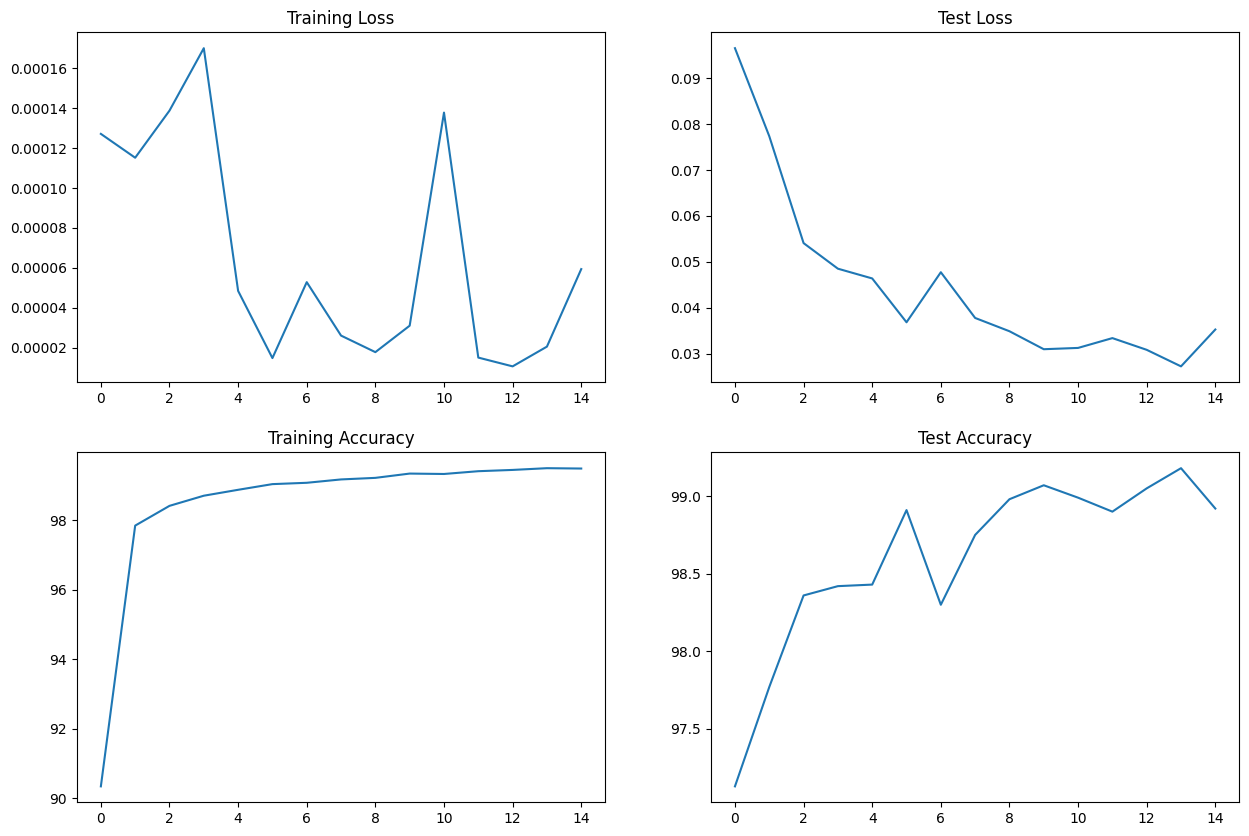

In [11]:
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")